In [20]:
import fcl 
import math 
import numpy as np 
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from tf.transformations import quaternion_from_euler 

print("Packages Loaded.")

Packages Loaded.


## Tutorial: Flexible Collision Library 

In [21]:
def make_box(name, pos, rot, size): 
    return {"name":name, "type":"box", "info":pos+rot+size}



""" Flexible Collision Library """
class PyFCL:
    def __init__(self, _num_max_contacts = 100, _verbose = True):
        self.geom_lst = []
        self.objs_lst = []
        self.name_lst = [] 
        self.verbose  = _verbose
        self.req      = fcl.CollisionRequest()
        self.res      = fcl.CollisionResult()
        self.cdata    = fcl.CollisionData(request = self.req)

    # capsule type: [position[0], position[1], position[2], rpy[0], rpy[1], rpy[2], height, radius]
    # box type: [position[0], position[1], position[2], rpy[0], rpy[1], rpy[2], size[0], size[1], size[2]]
    def fclize_obj(self, obj_info): 
        obj_name = obj_info["name"]
        obj_type = obj_info["type"]
        obj_pos  = obj_info["position"]
        obj_rpy  = obj_info["orientation"]
        obj_size = obj_info["size"]

        if obj_type == "capsule":
            obj_height = obj_size[0]
            obj_radius = obj_size[1]
            obj_q = quaternion_from_euler (obj_rpy[0], obj_rpy[1], obj_rpy[2]) 
            obj_t = np.array(obj_pos)
            obj_g = fcl.Capsule(obj_radius, obj_height)
            obj_t = fcl.Transform(obj_q, obj_t)
            obj_o = fcl.CollisionObject(obj_g, obj_t)
 
        if obj_type == "box": 
            obj_q = quaternion_from_euler (obj_rpy[0], obj_rpy[1], obj_rpy[2]) 
            obj_t = np.array(obj_pos)            
            obj_g = fcl.Box(obj_size[0], obj_size[1], obj_size[2])
            obj_t = fcl.Transform(obj_q, obj_t)
            obj_o = fcl.CollisionObject(obj_g, obj_t)
        self.geom_lst.append(obj_g)
        self.objs_lst.append(obj_o)
        self.name_lst.append(obj_name)
        return obj_o 

    def one2one_cc(self, fclize_obj1, fclize_obj2):
        collision = fcl.collide(fclize_obj1, fclize_obj2, self.req, self.res)
        """ Collision Check """
        if collision: 
            if self.verbose: 
                print("Collision Detection")
            return True # Collision detection
        else: 
            if self.verbose: 
                print("Collision Free")
            return False  # Collision free 

    def one2many_cc(self, obj, obj_list):
        manager = fcl.DynamicAABBTreeCollisionManager()
        manager.registerObjects(obj_list)
        manager.setup()
        manager.collide(obj, self.cdata, fcl.defaultCollisionCallback)
        collision = self.cdata.result.is_collision
        if self.verbose: 
            objs_in_collision = set() 
            # Create map from geometry IDs to objects
            geom_id_to_obj  = {id(geom) : obj for geom, obj in zip(self.geom_lst, self.objs_lst)}
            # Create map from geometry IDs to string names
            geom_id_to_name = {id(geom) : name for geom, name in zip(self.geom_lst, self.name_lst)}
            for contact in self.cdata.result.contacts:
                coll_geom_0 = contact.o1
                coll_geom_1 = contact.o2

                # Get their names
                coll_names = [geom_id_to_name[id(coll_geom_0)], geom_id_to_name[id(coll_geom_1)]]
                coll_names = tuple(sorted(coll_names))
                objs_in_collision.add(coll_names)

            for coll_pair in objs_in_collision:
                pass
                print('*WARNING* {} in collision with object {}!'.format(coll_pair[0], coll_pair[1]))
        """ Collision Check """
        if collision: 
            return True # Collision detection
        else: 
            print("Collision Free")
            return False  # Collision free 

In [22]:
""" Sample """
def make_obj(name, type, position, orientation, size): 
    return {"name":name, "type":type, "position":position, "orientation":orientation, "size":size}

obj_info_lst = []
objinfo1 = make_obj(name="obs1", type="box", position=[3,3,-3], orientation=[0,0,0], size=[1,1,1])
obj_info_lst.append(objinfo1)

objinfo2 = make_obj(name="obs2", type="box", position=[-3.5,-2.5,-2], orientation=[0,0,0], size=[1,1,1])
obj_info_lst.append(objinfo2)

objinfo3 = make_obj(name="obs3", type="box", position=[-2,1,4], orientation=[0,0,0], size=[1,1,1])
obj_info_lst.append(objinfo3)

objinfo4 = make_obj(name="obs4", type="box", position=[-1.5,-2,-2], orientation=[0,0,0], size=[1,1,1])
obj_info_lst.append(objinfo4)

objinfo5 = make_obj(name="obs5", type="box", position=[0,1.3,-2], orientation=[0,0,0], size=[1,1,1])
obj_info_lst.append(objinfo5)

objinfo6 = make_obj(name="obs6", type="box", position=[2.2,1,1], orientation=[0,0,0], size=[1,1,1])
obj_info_lst.append(objinfo6)

objinfo7 = make_obj(name="obs7", type="box", position=[1.4,1,1], orientation=[0,0,0], size=[1,1,1])
obj_info_lst.append(objinfo7)


### One to Many Collision Check

In [23]:
""" Object Instance """
fclize = PyFCL() 

obs1 = fclize.fclize_obj(objinfo1)
obs2 = fclize.fclize_obj(objinfo2)
obs3 = fclize.fclize_obj(objinfo3)
obj_list = [obs2,obs3]

""" Check Collision """
one2many_result = fclize.one2many_cc(obs1 , obj_list)
print("Is collision? %s"%one2many_result)


Collision Free
Is collision? False


### One to One Collision Check 

In [24]:
""" Object Instance """
fclize = PyFCL() 

obs4 = fclize.fclize_obj(objinfo4)
obs5 = fclize.fclize_obj(objinfo5)
obs6 = fclize.fclize_obj(objinfo6)
obs7 = fclize.fclize_obj(objinfo7)

""" Check Collision """
one2one_result = fclize.one2one_cc(obs4, obs5)
print("Is collision? %s"%one2one_result)

one2one_result2 = fclize.one2one_cc(obs6, obs7)
print("Is collision? %s"%one2one_result2)

Collision Free
Is collision? False
Collision Detection
Is collision? True


### Visualization 

In [25]:
""" 3D-Box Visualization Tool """

def cuboid_data(o, size=(1,1,1)):
    l, w, h = size
    x = [[o[0], o[0] + l, o[0] + l, o[0], o[0]],  
         [o[0], o[0] + l, o[0] + l, o[0], o[0]],  
         [o[0], o[0] + l, o[0] + l, o[0], o[0]],  
         [o[0], o[0] + l, o[0] + l, o[0], o[0]]]  
    y = [[o[1], o[1], o[1] + w, o[1] + w, o[1]],  
         [o[1], o[1], o[1] + w, o[1] + w, o[1]],  
         [o[1], o[1], o[1], o[1], o[1]],          
         [o[1] + w, o[1] + w, o[1] + w, o[1] + w, o[1] + w]]   
    z = [[o[2], o[2], o[2], o[2], o[2]],                       
         [o[2] + h, o[2] + h, o[2] + h, o[2] + h, o[2] + h],   
         [o[2], o[2], o[2] + h, o[2] + h, o[2]],               
         [o[2], o[2], o[2] + h, o[2] + h, o[2]]]               
    return np.array(x), np.array(y), np.array(z)

def plotCubeAt(pos=(0,0,0), size=(1,1,1), ax=None,**kwargs):
    # Plotting a cube element at position pos
    if ax !=None:
        X, Y, Z = cuboid_data( pos, size )
        ax.plot_surface(X, Y, Z, rstride=1, cstride=1, **kwargs)

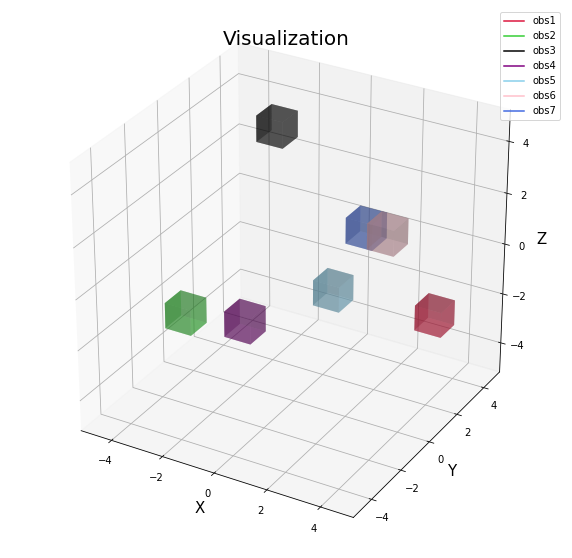

In [26]:

""" Get object information """
viz_pos_lst  = []
viz_name_lst = []
viz_size_lst = [] 

for obj_info in obj_info_lst: 
      viz_name_lst.append(obj_info["name"])
      viz_pos_lst.append(obj_info["position"])
      viz_size_lst.append(obj_info["size"])

""" Plot """
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.axis([-5, 5, -5, 5])
ax.set_zlim(-5,5)
ax.set_xlabel("X", fontsize=15)
ax.set_ylabel("Y", fontsize=15)
ax.set_zlabel("Z", fontsize=15)
colors = ["crimson","limegreen", "black",  "purple", "skyblue", "pink", "royalblue","seagreen" ]

for pos, name, color in zip(viz_pos_lst, viz_name_lst, colors):
      ax.plot([pos[0]], [pos[1]], [pos[2]], color=color, label=name)
for pos, size, color in zip(viz_pos_lst, viz_size_lst, colors):
      plotCubeAt(pos=pos, size=size, ax=ax, color=color, alpha=0.3)
      
ax.set_title("Visualization", fontsize=20)
ax.legend()
